## Dataset disponibilizado pelo sklearn contendo as variáveis independentes e o valor das casas, que será nosso target

### Como o banco de dados dos preços das casas de Boston disponibilizado pelo SKLearn foi descontinuado por causa de problemas éticos relacionados aos dados, iremos ignorar os avisos com a biblioteca warnings, porém fique avisado que no futuro não será mais possível carregar esse banco de dados via SKLearn.

In [1]:
#Biblioteca necessária para ler os dados das casas de Boston
from sklearn.datasets import load_boston

#Para ignorar os erros citados no começo do caderno
import warnings 
warnings.simplefilter(action='ignore')

#Biblioteca para plotar os gráficos dos boxplots e verificar os outliers 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split, GridSearchCV 

#Modelos utilizados
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR 
from sklearn.neural_network import MLPRegressor

#Bibliotecas para normalizar os dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd 
import numpy as np

from xgboost import XGBRegressor 

In [2]:
#Lendo o arquivo e criando um dataframe com as colunas dos features names
housing = load_boston()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
display(df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [3]:
#Informação sobre as colunas do dataframe 
print(housing.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Verificando os outliers

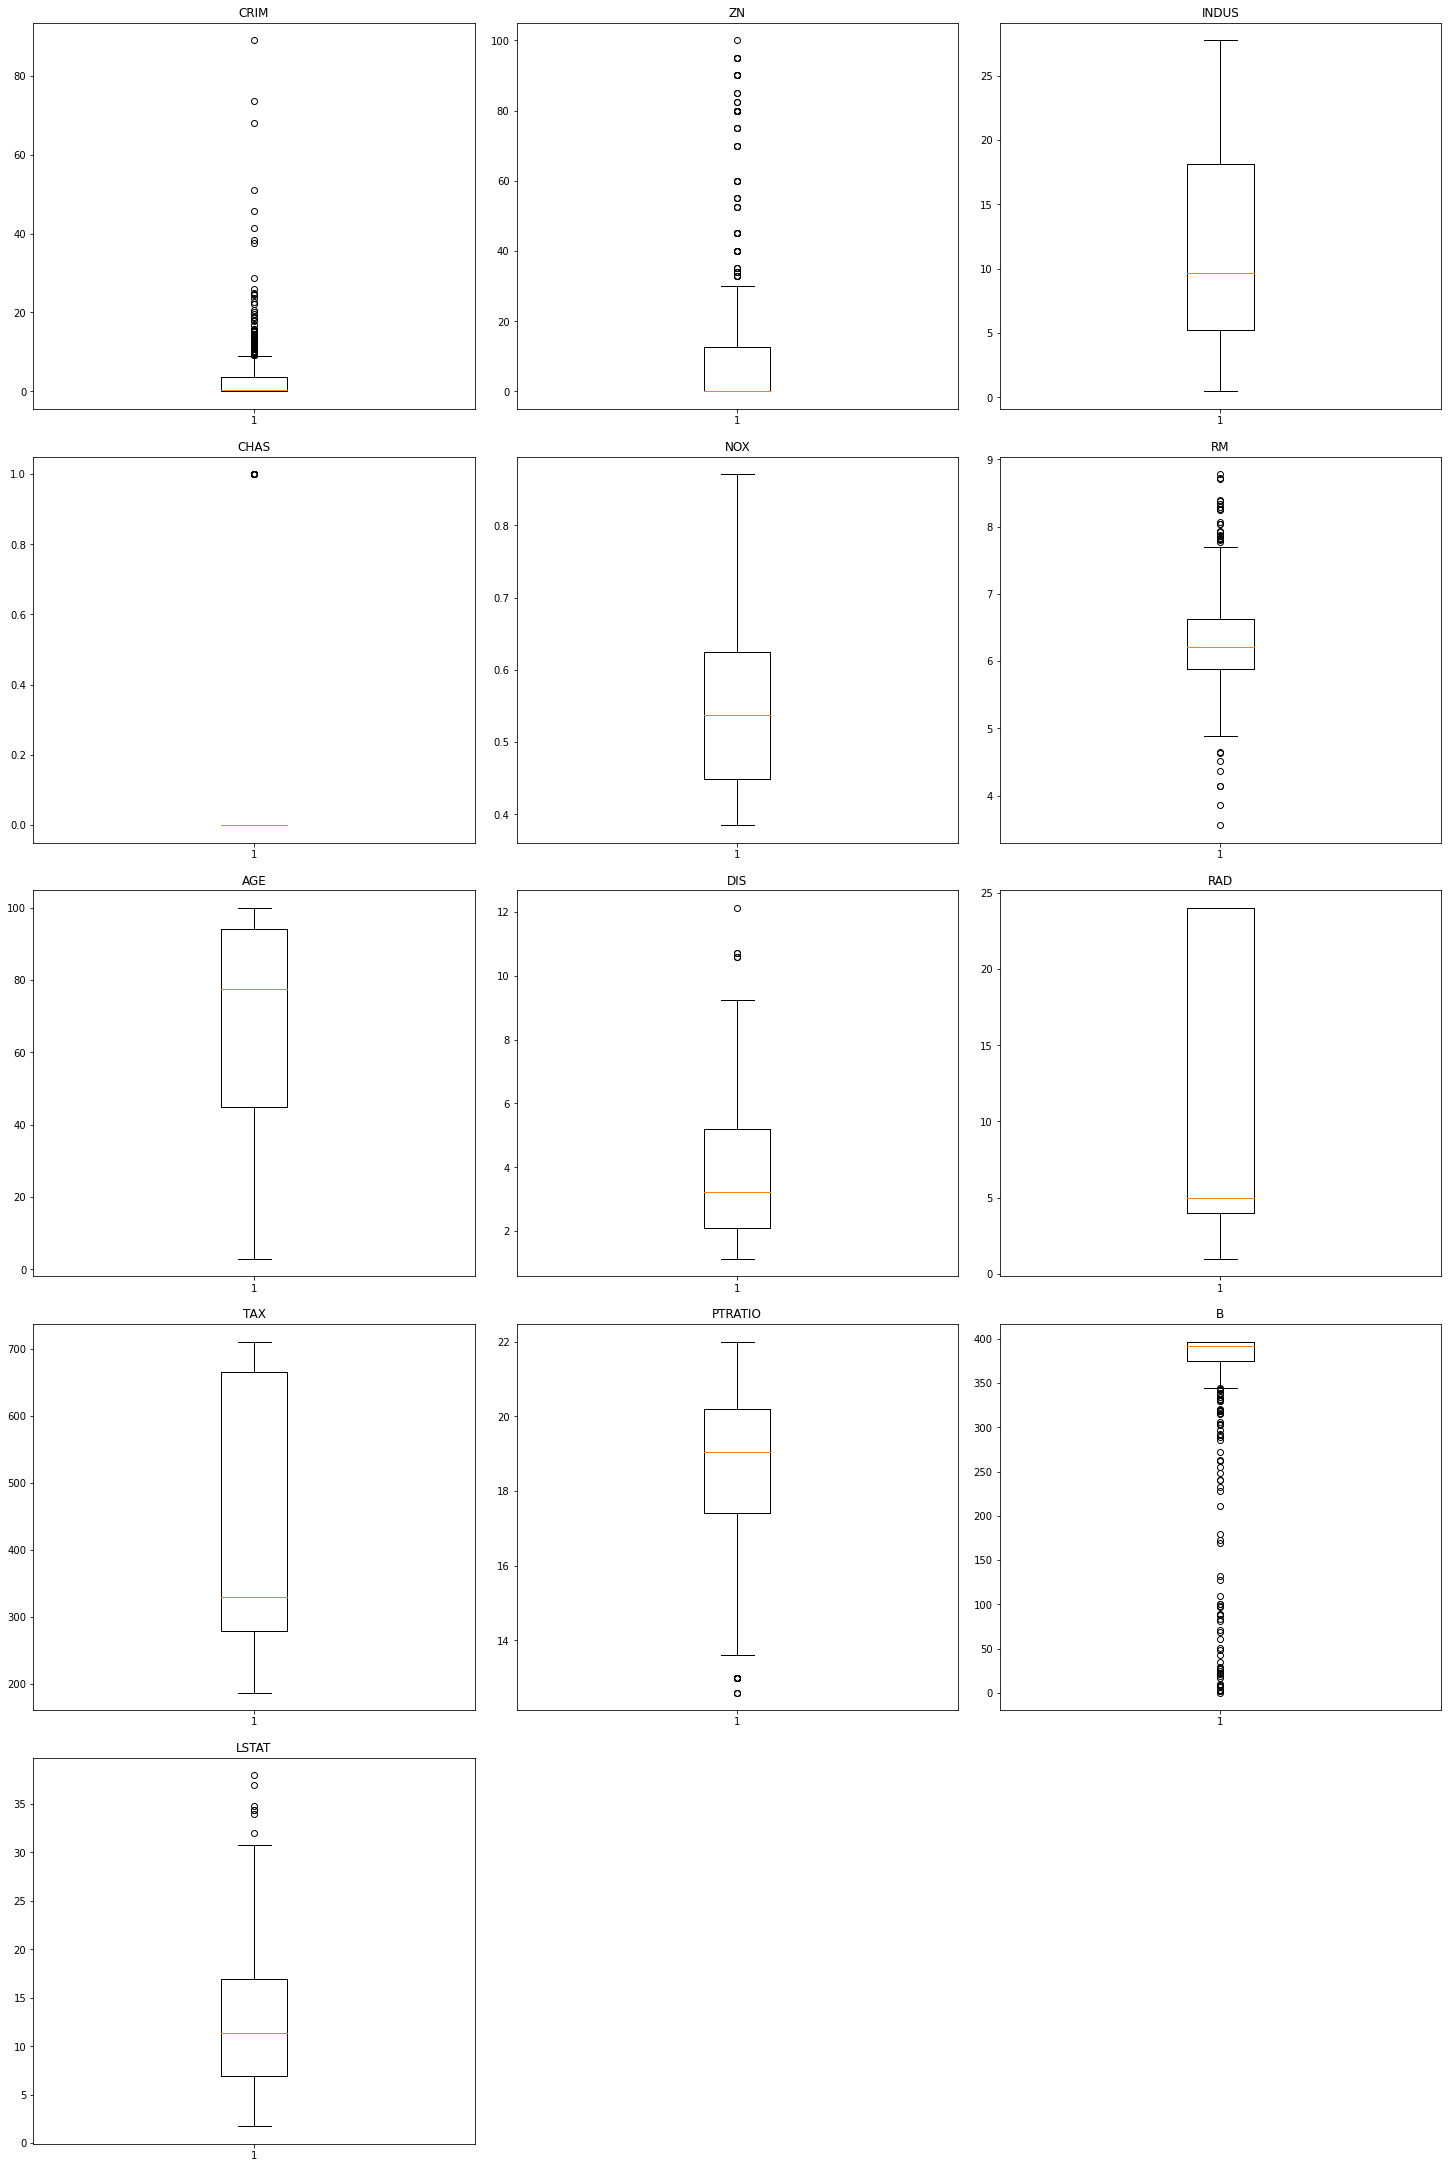

In [4]:
def desenhar_boxplots(df, features):
    n = len(features)
    fig = plt.figure(constrained_layout=True, figsize=(20,30))
    gs = gridspec.GridSpec(int(n/3) + 1, 3, figure=fig)
    
    for i in range(n):
        k = int(i/3)
        j = i % 3
        col = features[i]
        ax = fig.add_subplot(gs[k, j])
        ax.set_title(col)
        ax.boxplot(df[col])

def substituir_outliers(df, var_names):
    for var_name in var_names:
        #Calculando o Q1 e o Q3 
        Q1 = df.loc[:, var_name].quantile(0.25)
        Q3 = df.loc[:, var_name].quantile(0.75)
        #Calculando o IQR (Interquantile Range)
        IQR = Q3 - Q1 
        #Criando um filtro para encontrar outliers
        filtro = (df.loc[:, var_name] > Q3 + 1.5 * IQR)
        #Aplicando o filtro
        df.loc[filtro, var_name] = Q3 + 1.5 * IQR
        
        filtro_baixo = (df.loc[:, var_name] < Q1 - 1.5 * IQR)
        df.loc[filtro_baixo, var_name] = Q1 - 1.5 * IQR
        
        
        
desenhar_boxplots(df, df.columns)
#Testando o modelo com e sem a substituição dos outliers
#substituir_outliers(df, df.columns)


## Separando entre treino e teste

In [5]:
#Caracteristicas das casas que serão as features do modelo 
X = housing.data 
#Preço conhecido das casas, nosso target 
y = housing.target 

#Separar entre treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalizando os dados

In [6]:
standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train = standardscaler.transform(X_train)
X_test = standardscaler.transform(X_test)

## Técnica 1: Regressão Linear

In [7]:
regressaoLinear = LinearRegression().fit(X_train,y_train)
yLinear = regressaoLinear.predict(X_test)

print(f'MSE Linear: {mean_squared_error(y_test, yLinear)}')
print(f'RMSE Linear: {np.sqrt(mean_squared_error(y_test, yLinear))}')
print(f'MAE Linear: {mean_absolute_error(y_test, yLinear)}')
print(f'R-Squared Linear: {r2_score(y_test, yLinear)}')

MSE Linear: 24.291119474973527
RMSE Linear: 4.928602182665338
MAE Linear: 3.1890919658878465
R-Squared Linear: 0.6687594935356318


## Técnica 2: SVR

In [8]:
regressaoSVR = SVR().fit(X_train, y_train)
ySVR = regressaoSVR.predict(X_test)

print(f'MSE SVR: {mean_squared_error(y_test, ySVR)}')
print(f'RMSE SVR: {np.sqrt(mean_squared_error(y_test, ySVR))}')
print(f'MAE SVR: {mean_absolute_error(y_test, ySVR)}')
print(f'R-Squared SVR: {r2_score(y_test, ySVR)}')

MSE SVR: 25.66853967839608
RMSE SVR: 5.066412900504269
MAE SVR: 2.731716176155842
R-Squared SVR: 0.649976605976003


## Técnica 3: XGBoost Regressor

In [9]:
regressaoXGB = XGBRegressor().fit(X_train, y_train)
yXGB = regressaoXGB.predict(X_test)

print(f'MSE XGB: {mean_squared_error(y_test, yXGB)}')
print(f'RMSE XGB: {np.sqrt(mean_squared_error(y_test, yXGB))}')
print(f'MAE XGB: {mean_absolute_error(y_test, yXGB)}')
print(f'R-Squared XGB: {r2_score(y_test, yXGB)}')

MSE XGB: 6.735976212796364
RMSE XGB: 2.5953759289930165
MAE XGB: 1.9662464057697968
R-Squared XGB: 0.9081463423471537


In [10]:
parameters = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'eta': [0.1,0.2,0.3],
    "objective": ['reg:squarederror'],
    "booster": ['gbtree'],
    "n_jobs": [5],
    "gamma": [0, 1],
    "min_child_weight": [1,3],
    "max_delta_step": [0,1],
    "subsample": [0.5, 1]
}

XGBGrid = GridSearchCV(XGBRegressor(), parameters)

XGBGridModel = XGBGrid.fit(X_train, y_train)
yGrid = XGBGridModel.predict(X_test)

print(f'MSE XGB com GridSearch: {mean_squared_error(y_test, yGrid)}')
print(f'RMSE XGB com GridSearch: {np.sqrt(mean_squared_error(y_test, yGrid))}')
print(f'MAE XGB com GridSearch: {mean_absolute_error(y_test, yGrid)}')
print(f'R-Squared XGB com GridSearch: {r2_score(y_test, yGrid)}')

MSE XGB com GridSearch: 7.530607328787482
RMSE XGB com GridSearch: 2.7441952060280776
MAE XGB com GridSearch: 1.9902762693517346
R-Squared XGB com GridSearch: 0.8973105299596503


## Técnica 4: MLP Scikit Learn 

In [11]:
MLP = MLPRegressor().fit(X_train, y_train)
yMLP = MLP.predict(X_test)
MSEMLP = mean_squared_error(y_test, yMLP)
MAEMLP = mean_absolute_error(y_test, yMLP)

print(f'MSE MLP: {mean_squared_error(y_test, yMLP)}')
print(f'RMSE MLP: {np.sqrt(np.sqrt(mean_squared_error(y_test, yMLP)))}')
print(f'MAE MLP: {mean_absolute_error(y_test, yMLP)}')
print(f'R-Squared MLP: {r2_score(y_test, yMLP)}')

MSE MLP: 27.243387201729842
RMSE MLP: 2.2846268458599344
MAE MLP: 3.5408186181477848
R-Squared MLP: 0.6285015442041206
